<a href="https://www.kaggle.com/code/dalloliogm/predicting-using-a-logistic-regression-with-regula?scriptVersionId=228257663" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Rain prediction using Logistic Regression

This notebook predicts rainfall using a simple Logistic Regression model.

## Parameters and options

In [1]:
config = {
    "clustering_variables": ['day', 'temparature', 'sunshine', 'cloud', 'windspeed'],
    "n_clusters": 3,
    "n_lags": 5,
    "lag_columns": ['humidity', 'temparature', 'pressure', 'cloud', 'windspeed', 'dewpoint', 'sunshine']
}

## Importing libraries and reading files

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [3]:
!head /kaggle/input/playground-series-s5e3/sample_submission.csv
!head /kaggle/input/playground-series-s5e3/train.csv
!head /kaggle/input/playground-series-s5e3/test.csv

id,rainfall
2190,0
2191,0
2192,0
2193,0
2194,0
2195,0
2196,0
2197,0
2198,0
id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
5,6,1022.7,20.6,18.6,16.5,12.5,79.0,81.0,0.0,20.0,15.7,1
6,7,1022.8,19.5,18.4,15.3,11.3,56.0,46.0,7.6,20.0,28.4,0
7,8,1019.7,15.8,13.6,12.7,11.8,96.0,100.0,0.0,50.0,52.8,1
8,9,1017.4,17.6,16.5,15.6,12.5,86.0,100.0,0.0,50.0,37.5,1
id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
2193,4,1022.9,20.6,17.3,15.2,

In [4]:
train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")#.set_index("id")
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [5]:
train.describe().style.background_gradient(cmap='summer')

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [6]:
train.day.max()

365

In [7]:
train.day.value_counts()

day
91     7
144    7
267    7
140    7
111    7
      ..
157    5
286    5
38     5
336    5
365    5
Name: count, Length: 365, dtype: int64

In [8]:
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")#.set_index("id")
test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


## Quick EDA

In [9]:


#sns.pairplot(train, kind="kde")

## Handling Missing values

It seems there is just one missing value, in the test dataset

In [10]:
train.isnull().sum()


id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [11]:
test.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [12]:

test[test.isnull().any(axis=1)]


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
517,2707,153,1007.8,32.9,30.6,28.9,22.0,65.0,75.0,8.2,NaN,17.2


## Feature Engineering

### Adding season (spring, summer, fall, winter) and cyclical features

The day variables goes from 1 to 365, so we only have data from one year.

To tell our model that day 1 is close to day 365 (as they are both in winter) we add a cyclical feature

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class SeasonMonthTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # Nothing to fit for this transformer
        return self
    
    def transform(self, X):
        # Make a copy to avoid modifying the original
        X_trans = X.copy()
        
        # Convert day -> month
        def day_to_month(day):
            if day%365 <= 31: return 1
            elif day%365 <= 59: return 2
            elif day%365 <= 90: return 3
            elif day%365 <= 120: return 4
            elif day%365 <= 151: return 5
            elif day%365 <= 181: return 6
            elif day%365 <= 212: return 7
            elif day%365 <= 243: return 8
            elif day%365 <= 273: return 9
            elif day%365 <= 304: return 10
            elif day%365 <= 334: return 11
            else: return 12
        
        X_trans['month'] = X_trans['day'].apply(day_to_month)
        
        # Convert day -> season
        def day_to_season(day):
            if 80 <= day%365 < 172:
                return 'spring'
            elif 172 <= day%365 < 264:
                return 'summer'
            elif 264 <= day%365 < 356:
                return 'autumn'
            else:
                return 'winter'
        
        X_trans['season'] = X_trans['day'].apply(day_to_season)

        
        X_trans['day_sin'] = np.sin(2 * np.pi * X_trans['day'] / 365)
        X_trans['day_cos'] = np.cos(2 * np.pi * X_trans['day'] / 365)
        
        # One-hot encode season
        X_trans = pd.get_dummies(X_trans, columns=['season'], drop_first=True)
        
        return X_trans



### Additional features

Inspired by https://www.kaggle.com/code/josephnehrenz/87-9-logistic-s5e3-rainfall-probability-in-r

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class AdditionalFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_trans = X.copy()
        
        # ------------------- Sunshine Metrics -------------------
        X_trans['relative_sunshine'] = X_trans['sunshine'] / (100 - X_trans['cloud'] + 1)
        X_trans['sunshine_ratio'] = X_trans['sunshine'] / (X_trans['cloud'] + X_trans['humidity'] + 1e-5)
        X_trans['cloud_sun_ratio'] = X_trans['cloud'] / (X_trans['sunshine'] + 1)
        X_trans['sunshine_pct'] = X_trans['sunshine'] / 24.0  # Assuming max sunshine is 24 hours
        
        # ------------------- Cloud Metrics -------------------
        # Compute cloud gradient using shift (lag)
        X_trans['cloud_gradient'] = X_trans['cloud'] - X_trans['cloud'].shift(1, fill_value=X_trans['cloud'].iloc[0])
        # Categorize cloud values into bins: 0-20, 20-50, 50-80, 80-100
        X_trans['cloud_category'] = pd.cut(X_trans['cloud'], bins=[0,20,50,80,100],
                                           labels=[0,1,2,3], include_lowest=True).astype(float)
        X_trans['sky_opacity'] = X_trans['cloud'] / 100.0
        
        # ------------------- Temperature Metrics -------------------
        X_trans['temp_range'] = X_trans['maxtemp'] - X_trans['mintemp']
        X_trans['temp_change'] = X_trans['temparature'] - X_trans['temparature'].shift(1, 
                                               fill_value=X_trans['temparature'].iloc[0])
        # Exponential moving average with span 10
        X_trans['temp_ewm'] = X_trans['temparature'].ewm(span=10, adjust=False).mean()
        X_trans['temp_humidity_interaction'] = X_trans['temparature'] + 0.2 * X_trans['humidity']
        
        # ------------------- Pressure Metrics -------------------
        # Rolling mean and std (window includes current and 6 previous values => window=7)
        X_trans['pressure_rolling_mean'] = X_trans['pressure'].rolling(window=7, min_periods=1).mean()
        X_trans['pressure_rolling_std'] = X_trans['pressure'].rolling(window=7, min_periods=1).std()
        X_trans['pressure_diff'] = X_trans['pressure'] - X_trans['pressure'].shift(1, 
                                              fill_value=X_trans['pressure'].iloc[0])
        
        # ------------------- Humidity Metrics -------------------
        X_trans['dewpoint_depression'] = X_trans['temparature'] - X_trans['dewpoint']
        X_trans['rh_approx'] = 100 - (5 * X_trans['dewpoint_depression'])
        X_trans['humidity_cloud_interaction'] = (X_trans['humidity'] * X_trans['cloud']) / 10000.0
        X_trans['inv_humidity_cloud'] = 100 - X_trans['humidity'] - X_trans['cloud']
        
        # ------------------- Dewpoint Metrics -------------------
        X_trans['svp'] = 6.1078 * np.exp((17.27 * X_trans['temparature']) / (X_trans['temparature'] + 237.3))
        X_trans['abs_humidity'] = (6.112 * np.exp((17.67 * X_trans['temparature']) / (X_trans['temparature'] + 243.5)) * 
                                   X_trans['humidity'] * 2.1674) / (273.15 + X_trans['temparature'])
        
        return X_trans


### Lagging features

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class LagFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, n_lags=5):
        """
        Parameters:
            columns: list of column names to create lag features for.
                     If None, defaults to ['humidity', 'temparature', 'pressure', 'sunshine'].
            n_lags: number of previous days (lags) to include.
        """
        self.columns = columns if columns is not None else ['humidity', 'temparature', 'pressure', 'sunshine']
        self.n_lags = n_lags
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create a copy so we don't modify the original DataFrame
        X_trans = X.copy()
        for col in self.columns:
            for lag in range(1, self.n_lags + 1):
                # Create a new column for each lag value
                X_trans[f"{col}_lag_{lag}"] = X_trans[col].shift(lag)
        return X_trans


## Predicting Clusters

Thanks to this notebook: https://www.kaggle.com/code/felixleung/looks-like-there-are-3-clusters


In [16]:
train.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

In [17]:
from sklearn.cluster import KMeans
import pandas as pd

# Suppose you use the 'day' column (or any set of features) for clustering
kmeans = KMeans(n_clusters=config["n_clusters"], random_state=42)

# Fit on training data
train['cluster'] = kmeans.fit_predict(train[config["clustering_variables"]])
# Predict clusters for test data using the same model
test['cluster'] = kmeans.predict(test[config["clustering_variables"]])

# One-hot encode the cluster labels (optional but recommended)
train = pd.get_dummies(train, columns=['cluster'], prefix='cluster')
test = pd.get_dummies(test, columns=['cluster'], prefix='cluster')


In [18]:
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,cluster_0,cluster_1,cluster_2
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,False,False,True
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,False,False,True
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,False,False,True
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,False,False,True
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,False,False,True


## Prediction using Logistic Regression

In [19]:
[c for c in train.columns if c.startswith('cluster')]


['cluster_0', 'cluster_1', 'cluster_2']

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
import numpy as np
from lightgbm import LGBMClassifier


# Define a helper function to create the pipeline
def create_pipeline(lag_columns = config["lag_columns"], 
                    n_lags=config["n_lags"], 
                    clf=False):
    steps = [
        ('feature_eng', SeasonMonthTransformer()),
        ('additional_fe', AdditionalFeatureTransformer()),
        ('lag_features', LagFeatureTransformer(columns=lag_columns, n_lags=n_lags)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ]
    return Pipeline(steps)

# Define your feature columns and data
features = ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 
            'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 
             *[c for c in train.columns if c.startswith('cluster')]]

X = train[features]
y = train['rainfall']

# Create the logistic regression pipeline
pipeline_lr = create_pipeline(
    n_lags = config["n_lags"],
    lag_columns = config["lag_columns"],
    clf=LogisticRegression(
        penalty='l1',        # L1 (Lasso) regularization
        C=1.0,               # adjust for stronger/weaker regularization
        max_iter=1000,
        random_state=42,
        solver='liblinear'   # supports L1 penalty
    )
)

# Create the XGBoost pipeline 
pipeline_xgb = create_pipeline(
    n_lags = config["n_lags"],
    lag_columns = config["lag_columns"],
    clf=XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        colsample_bytree=0.9, 
        subsample=0.9,
        use_label_encoder=False,    # Disable label encoder to avoid warnings
        eval_metric='auc'           # Set evaluation metric to AUC
    )
)



# Create the XGBoost pipeline (with a different lag configuration)
pipeline_lgbm = create_pipeline(
    n_lags = config["n_lags"],
    lag_columns = config["lag_columns"],
    clf=LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbose=-1  # This will suppress the warnings
    )
)



In [21]:
print(features)

['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'cluster_0', 'cluster_1', 'cluster_2']


Repeated CV AUC scores: [0.90521886 0.85813692 0.8986532  0.87508418 0.89099327 0.91854658
 0.88257576 0.91007295 0.86655443 0.8640853  0.87368126 0.86630191
 0.88684063 0.90993266 0.88386644 0.90387205 0.8506734  0.88560606
 0.91209315 0.89113356 0.86105499 0.88148148 0.90948373 0.88900112
 0.8869248  0.86122334 0.88364198 0.89747475 0.91820988 0.8733165
 0.8708193  0.89486532 0.89559484 0.87034231 0.88145342 0.84901796
 0.87528058 0.89834456 0.90286195 0.92960157 0.91964085 0.92258698
 0.82039843 0.87104377 0.90072952 0.87351291 0.90544332 0.87732884
 0.88159371 0.90126263]
Mean AUC Logistic Regression: 0.8867491582491582


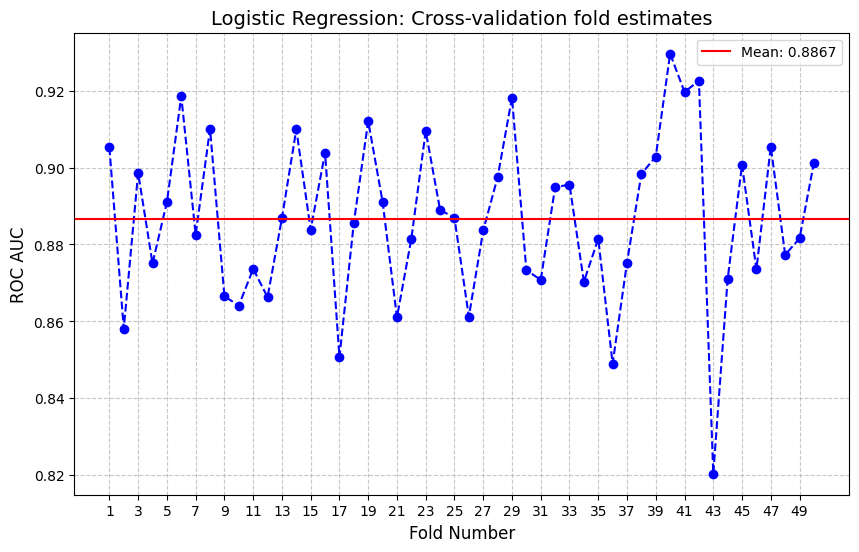

In [22]:
# Evaluate the logistic regression pipeline using repeated stratified 5-fold CV
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=666)
cv_scores = cross_val_score(pipeline_lr, X, y, cv=rskf, scoring=auc_scorer)

mean_cv_scores_lg = np.mean(cv_scores)
print("Repeated CV AUC scores:", cv_scores)
print("Mean AUC Logistic Regression:", mean_cv_scores_lg)

# Code inspired by https://www.kaggle.com/code/nikita7364777/lb-0-863-stacking-v2
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), cv_scores, marker='o', linestyle='--', color='b')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='-', 
            label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.title('Logistic Regression: Cross-validation fold estimates', fontsize=14)
plt.xticks(range(1, 50, 2))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Repeated CV AUC scores: [0.90516274 0.85448934 0.88630752 0.87819865 0.88644781 0.91338384
 0.88108866 0.89971942 0.85106622 0.86060606 0.86599327 0.86234568
 0.88285634 0.91127946 0.88010662 0.90106622 0.83215488 0.87685185
 0.89840067 0.90283389 0.87205387 0.87833895 0.89901796 0.87281145
 0.88498878 0.86703143 0.88681257 0.88316498 0.90002806 0.86806958
 0.867789   0.89155443 0.89725028 0.85970819 0.88033109 0.85199214
 0.8674523  0.89396745 0.88375421 0.91265432 0.91127946 0.91689113
 0.82828283 0.87662738 0.89363075 0.86655443 0.91301908 0.87976992
 0.87710438 0.89079686]
Mean AUC XGBoost: 0.8820617283950617


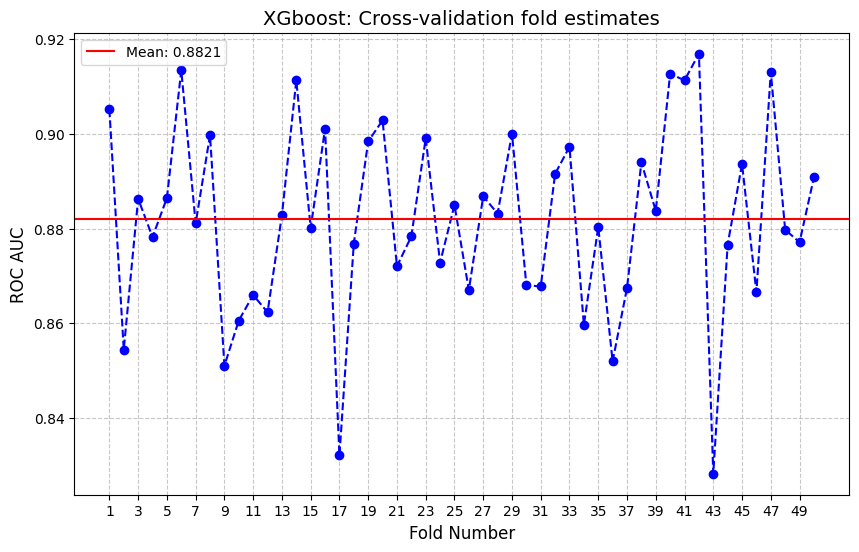

In [23]:
# Evaluate the logistic regression pipeline using repeated stratified 5-fold CV
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=666)
cv_scores_xgb = cross_val_score(pipeline_xgb, X, y, cv=rskf, scoring=auc_scorer)
mean_cv_scores_xgb = np.mean(cv_scores_xgb)

print("Repeated CV AUC scores:", cv_scores_xgb)
print("Mean AUC XGBoost:", np.mean(cv_scores_xgb))

# Code inspired by https://www.kaggle.com/code/nikita7364777/lb-0-863-stacking-v2
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), cv_scores_xgb, marker='o', linestyle='--', color='b')
plt.axhline(y=cv_scores_xgb.mean(), color='r', linestyle='-', 
            label=f'Mean: {cv_scores_xgb.mean():.4f}')
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.title('XGboost: Cross-validation fold estimates', fontsize=14)
plt.xticks(range(1, 50, 2))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Repeated CV AUC scores: [0.90726712 0.85056117 0.88549383 0.88742985 0.88209877 0.90667789
 0.87881594 0.89492144 0.85       0.85625701 0.87370932 0.86689113
 0.8812009  0.90984848 0.88622334 0.89946689 0.82929293 0.87017396
 0.89172278 0.89382716 0.87511223 0.87859147 0.90280584 0.8694725
 0.88613917 0.86941639 0.88425926 0.86857464 0.90025253 0.88027497
 0.8647587  0.89523008 0.89621212 0.860578   0.87873176 0.85737935
 0.86860269 0.90019641 0.88442761 0.90968013 0.90238496 0.91346801
 0.82023008 0.86969697 0.88588664 0.87070707 0.90662177 0.878367
 0.87932099 0.88246352]
Mean AUC LightGBM: 0.8808344556677891


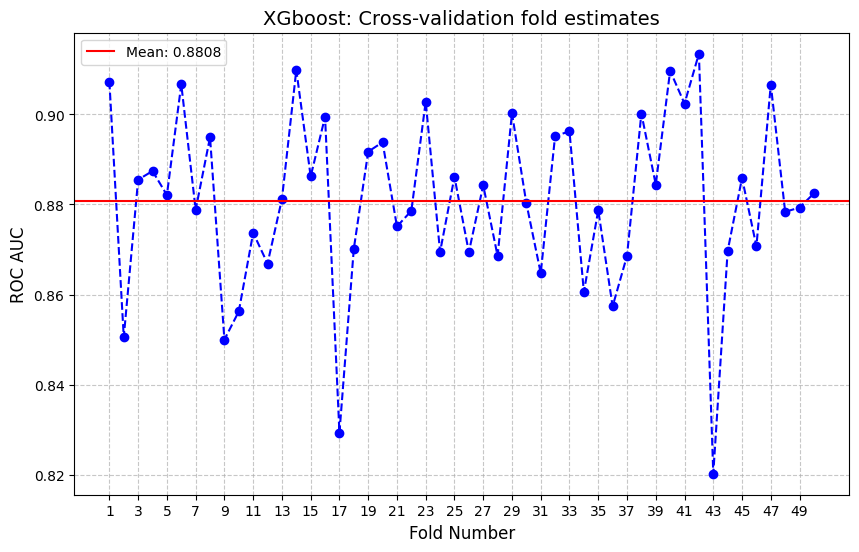

In [24]:
# Evaluate the logistic regression pipeline using repeated stratified 5-fold CV
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=666)
cv_scores_lgbm = cross_val_score(pipeline_lgbm, X, y, cv=rskf, scoring=auc_scorer)
mean_cv_scores_lgbm = np.mean(cv_scores_lgbm)

print("Repeated CV AUC scores:", cv_scores_lgbm)
print("Mean AUC LightGBM:", np.mean(cv_scores_lgbm))

# Code inspired by https://www.kaggle.com/code/nikita7364777/lb-0-863-stacking-v2
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), cv_scores_lgbm, marker='o', linestyle='--', color='b')
plt.axhline(y=cv_scores_lgbm.mean(), color='r', linestyle='-', 
            label=f'Mean: {cv_scores_lgbm.mean():.4f}')
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.title('XGboost: Cross-validation fold estimates', fontsize=14)
plt.xticks(range(1, 50, 2))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Choose a model

Modify this variable to choose which model to submit

In [25]:
# Dictionary mapping model names to their mean cross-validation scores
results = {"LG": mean_cv_scores_lg, "XGB": mean_cv_scores_xgb, "LGBM": mean_cv_scores_lgbm}

# Get the best model key and score
best_model, best_score = max(results.items(), key=lambda x: x[1])
print("Best model:", best_model, "with score:", best_score)

# Dictionary mapping model names to their corresponding pipelines
pipelines = {"LG": pipeline_lr, "XGB": pipeline_xgb, "LGBM": pipeline_lgbm}

# Assign the pipeline corresponding to the best model
pipeline = pipelines[best_model]


Best model: LG with score: 0.8867491582491582


In [26]:
#pipeline = pipeline_lg

## Fitting model

In [27]:
# Refit on the full training set to ensure coefficients are available
pipeline.fit(X, y)


Pipeline(steps=[('feature_eng', SeasonMonthTransformer()),
                ('additional_fe', AdditionalFeatureTransformer()),
                ('lag_features',
                 LagFeatureTransformer(columns=['humidity', 'temparature',
                                                'pressure', 'cloud',
                                                'windspeed', 'dewpoint',
                                                'sunshine'])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

## Visualizing Feature Importance

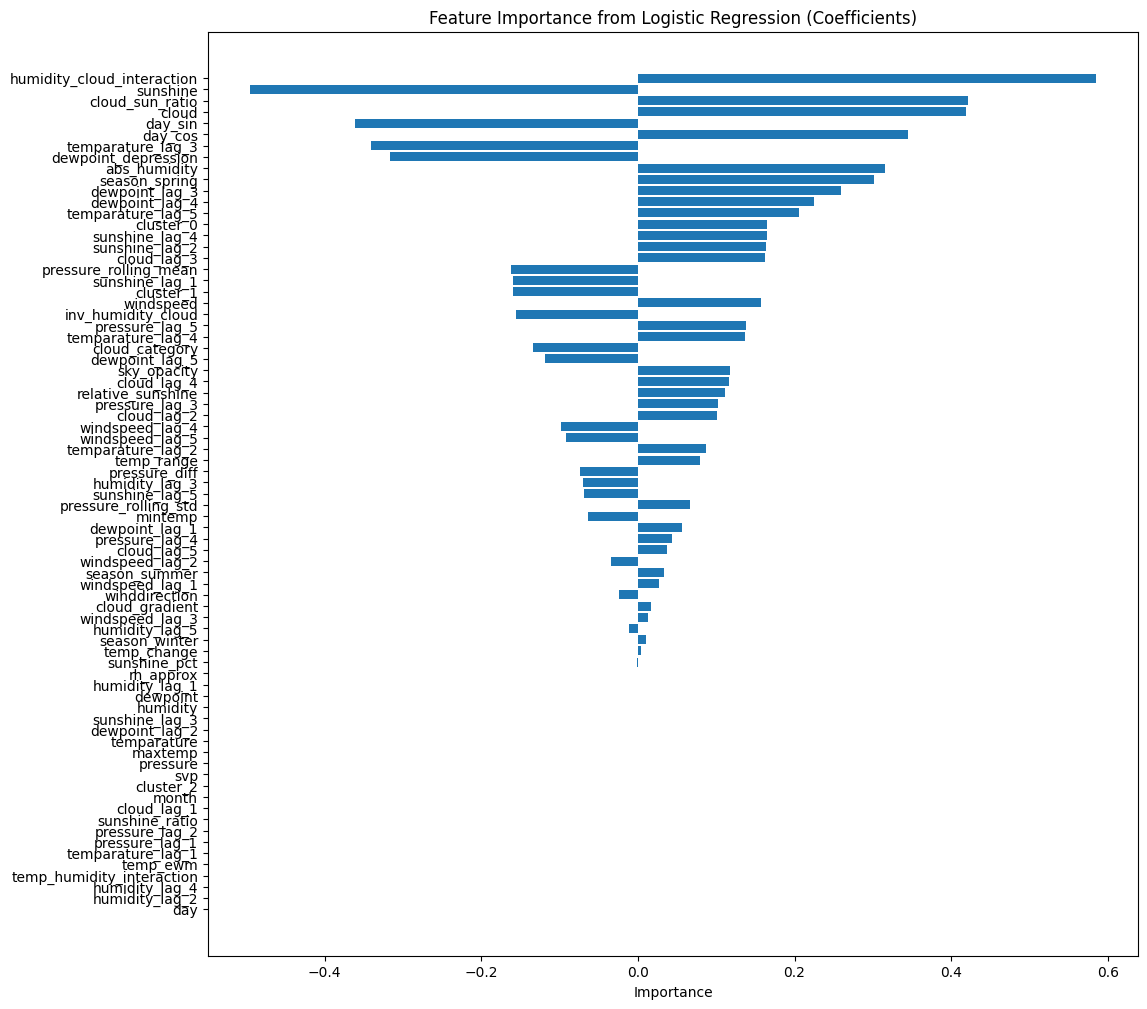

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Manually apply the feature engineering steps (skipping the imputer) to get the final feature names
X_season = pipeline.named_steps['feature_eng'].transform(X)
X_transformed = pipeline.named_steps['additional_fe'].transform(X_season)
X_transformed = pipeline.named_steps['lag_features'].transform(X_transformed)
feature_names = X_transformed.columns

clf = pipeline.named_steps['clf']

# Check if the classifier has 'coef_' (e.g. LogisticRegression) or 'feature_importances_' (e.g. XGBoost)
if hasattr(clf, "coef_"):
    # For linear models like LogisticRegression
    coefficients = clf.coef_[0]
    feat_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients
    })
    feat_importance['abs_importance'] = feat_importance['importance'].abs()
    feat_importance = feat_importance.sort_values('abs_importance', ascending=True)
    title = "Feature Importance from Logistic Regression (Coefficients)"
elif hasattr(clf, "feature_importances_"):
    # For tree-based models like XGBoost
    importances = clf.feature_importances_
    feat_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    feat_importance = feat_importance.sort_values('importance', ascending=True)
    title = "Feature Importance from XGBoost"
else:
    raise ValueError("Classifier does not have a known feature importance attribute.")

# Plot feature importance as a horizontal bar chart
plt.figure(figsize=(12, 12))
plt.barh(feat_importance['feature'], feat_importance['importance'])
plt.xlabel("Importance")
plt.title(title)
plt.show()


## Trying XGBoost and LightGBM

In [29]:
from lightgbm import LGBMClassifier

pipeline_lgb = Pipeline(steps=[
    ('feature_eng', SeasonMonthTransformer()),
    ('additional_fe', AdditionalFeatureTransformer()),
    ('lag_features', LagFeatureTransformer(columns=['humidity', 'temparature', 'pressure', 'sunshine'], n_lags=5)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbose=-1  # This will suppress the warnings
    ))
])


## Creating Submission file

In [30]:
X_test = test[features]
X_test

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,cluster_0,cluster_1,cluster_2
0,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3,False,False,True
1,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3,False,False,True
2,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9,False,False,True
3,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6,False,False,True
4,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,False,True,False
726,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,False,True,False
727,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,False,True,False
728,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5,False,True,False


In [31]:
pipeline_xgb.fit(X,y)
# Predict probabilities on the test set
test_preds = pipeline_xgb.predict_proba(X_test)[:, 1]

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'rainfall': test_preds
})

# Save the submission file
submission.to_csv('submission.csv', index=False)


In [32]:
test_preds[0:10]

array([0.9941246 , 0.99535924, 0.97250336, 0.16851225, 0.07674971,
       0.9639911 , 0.9701213 , 0.97796077, 0.9843435 , 0.90347576],
      dtype=float32)

In [33]:
submission.head()

,id,rainfall
0,2190,0.994125
1,2191,0.995359
2,2192,0.972503
3,2193,0.168512
4,2194,0.076750
